In [0]:
# default_exp data.exploratory.se.metrics

# Exploration of your data

> This module comprises some of the statistical and inference techniques to describe the inner properties of software data. The submodules might include:
>
> - Descriptive statistics
> - Software Metrics
> - Information Theory
> - Learning Principels Detection (Occams' Razor, Biased data, and Data Snooping)
> - Inference: Probabilistic and Causal

### Specifically in this module

> - Cyclomatic complexity (CYCLO)
> - Coupling Between Objects (CBO)
> - Lack of Cohesion of Methods 5 (LCOM5)
> - Top/Least 20 Occurring Tokens
> - Percentage of redundancy (just Java)
> - How many Type I and Type II clones are in Java datasets?

### Current limitations

> - Can only compute LCOM5 for java files
> - Can only read files encoded in utf-8 and iso-8859-15.
> - Can only compute Cyclomatic Complexity for 
> > - C
> > - C++ (works with C++14)
> > - Java
> > - C# (C Sharp)
> > - JavaScript (With ES6 and JSX)
> > - Objective-C
> > - Swift
> > - Python
> > - Ruby
> > - TTCN-3
> > - PHP
> > - Scala
> > - GDScript
> > - Golang
> > - Lua
> > - Rust

In [0]:
# #hide
# from nbdev.showdoc import *

In [1]:
# !pip install metrics # Outdated Cyclomatic Complexity tool
!pip install lizard
!pip install tree_sitter

     |████████████████████████████████| 61kB 2.0MB/s 
     |████████████████████████████████| 102kB 3.1MB/s 
  Created wheel for tree-sitter: filename=tree_sitter-0.1.0-cp36-cp36m-linux_x86_64.whl size=253716 sha256=0bdf871f77ce3b7d0c1d546858d7d6c4f6cc290b73663b6dd09f48d569fbdbe3
  Stored in directory: /root/.cache/pip/wheels/2b/f6/02/51f3b5a216c514a5a01dbdae46d4215670e326fe74855ce8c0
Successfully built tree-sitter


In [0]:
# export
# Imports
import pandas as pd
from numpy import mean, std
from statistics import median
from scipy.stats import sem, t
import lizard
import matplotlib.pyplot as plt
from tree_sitter import Language, Parser

# TODO: Remove when mongo call is implemented
import os

In [3]:
!git clone https://github.com/tree-sitter/tree-sitter-cpp
!git clone https://github.com/tree-sitter/tree-sitter-java

Cloning into 'tree-sitter-cpp'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 1305 (delta 34), reused 42 (delta 23), pack-reused 1244
Receiving objects: 100% (1305/1305), 38.10 MiB | 8.36 MiB/s, done.
Resolving deltas: 100% (852/852), done.
Cloning into 'tree-sitter-java'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 1418 (delta 77), reused 100 (delta 51), pack-reused 1285
Receiving objects: 100% (1418/1418), 12.87 MiB | 7.21 MiB/s, done.
Resolving deltas: 100% (897/897), done.


In [0]:
# TODO: Replace with actual mongo call
def simulate_getting_dataframes_from_mongo():
    corpus_data = {"system": [], "name": [], "ground_truth": [], "contents": [], "encoding": []}
    path = "./source_code"
    for file in os.listdir(path):
        if not os.path.isdir(os.path.join(path, file)):
            corpus_data["system"].append(None)
            corpus_data["name"].append(file)
            corpus_data["ground_truth"].append("src")
            try:
                enc = "iso-8859-15"
                with open (os.path.join(path, file), "r", encoding=enc) as f:
                    corpus_data['contents'].append(f.read())
                    corpus_data['encoding'].append(enc)
                    # print(f"File {file} encoded in {enc}")
            except UnicodeDecodeError:
                enc = "utf-8"
                with open (os.path.join(path, file), "r", encoding=enc) as f:
                    corpus_data['contents'].append(f.read())
                    corpus_data['encoding'].append(enc)
                    # print(f"File {file} encoded in {enc}")
    corpus_df = pd.DataFrame(data = corpus_data)
    return corpus_df

In [0]:
# export
def add_mccabe_metrics(df, data_col, name_col):
    """Adds information about function length and cyclomatic complexity to the corpus dataframe"""
    # TODO: Make sure that constructors are (or are not) being counted as a function
    num_funcs = []
    class_ccn = []
    avg_func_ccn = []
    avg_func_nloc = []
    # avg_func_tok_count = [] # TODO: Figure out how lizard tokenizes
    for i in range(len(df)):
        file_num_funcs = []
        file_class_ccn = []
        file_avg_func_ccn = []
        file_avg_func_nloc = []
        metrics = lizard.analyze_file.analyze_source_code(df[name_col][i], df[data_col][i])
        class_dict = {}
        for func in metrics.function_list:
            class_name = '::'.join(func.name.split("::")[:-1])
            if class_name in class_dict:
                class_dict[class_name].append(func)
            else:
                class_dict[class_name] = [func]
        for class_key in class_dict:
            total_class_ccn = 0
            total_class_nloc = 0
            for func in class_dict[class_key]:
                total_class_ccn += func.cyclomatic_complexity
                total_class_nloc += func.length
            file_num_funcs.append(len(class_dict[class_key]))
            file_class_ccn.append(total_class_ccn)
            file_avg_func_ccn.append(total_class_ccn/len(class_dict[class_key]))
            file_avg_func_nloc.append(total_class_nloc/len(class_dict[class_key]))

        num_funcs.append(file_num_funcs)
        class_ccn.append(file_class_ccn)
        avg_func_ccn.append(file_avg_func_ccn)
        avg_func_nloc.append(file_avg_func_nloc)


    df["num_funcs"] = num_funcs
    df["class_ccn"] = class_ccn
    df["avg_func_ccn"] = avg_func_ccn
    df["avg_func_nloc"] = avg_func_nloc
    # df["avg_func_tok_count"] = avg_func_tok_count # TODO: Figure out how lizard tokenizes
    return df

In [0]:
#export
def create_parser_builds(path=None):
    """Creates a dictionary of tree-sitter parsers for select languages"""
    Language.build_library(
        # Store the library in the `build` directory
        'build/my-languages.so',

        # Include one or more languages
        [
            'tree-sitter-cpp',
            'tree-sitter-java',
            # 'tree-sitter-javascript',
            # 'tree-sitter-python'
        ]
    )

    CPP_LANGUAGE = Language('build/my-languages.so', 'cpp')
    JAVA_LANGUAGE = Language('build/my-languages.so', 'java')
    # JS_LANGUAGE = Language('build/my-languages.so', 'javascript')
    # PY_LANGUAGE = Language('build/my-languages.so', 'python')
    
    return {'java':JAVA_LANGUAGE}

In [0]:
#export
def for_lang(extension):
    if extension == 'java':
        return {"class": "class_declaration", "method":"method_declaration"}

In [0]:
#export
def class_attributes_cpp(class_node, file_text, class_pattern):
    return 0

In [0]:
#export
def distinct_class_attribute_calls_cpp(class_node, atts, file_text):
    return 0

In [0]:
#export
def find_nodes(parent_node, pattern):
    node_list = []
    def rec_node_search(node):
        if node.type == pattern:
            node_list.append(node)
        for child in node.children:
            rec_node_search(child)
    rec_node_search(parent_node)
    return node_list

In [0]:
#export
def class_attributes_java(class_node, file_text, class_pattern):
    """Finds the fields/attributes for a class AST"""
    # TODO: Determine if this is rigourous enough for all files
    class_attributess = []
    # lines = file_text.split('\n')
    def rec_attribute_search(node):
        if node.type == "field_declaration":
            for c in range(len(node.children)):
                if node.children[c].type == "variable_declarator":
                    var_dec = node.children[c]
                    for d in range(len(var_dec.children)):
                        if var_dec.children[d].type == "identifier":
                            word = ""
                            for i in range(var_dec.children[d].start_byte, var_dec.children[d].end_byte):
                                word += file_text[i]
                            # for i in range(var_dec.children[d].start_point[1], var_dec.children[d].end_point[1]):
                            #     word += lines[var_dec.children[d].start_point[0]][i]
                            class_attributess.append(word)
        else:
            for child in node.children:
                if child.type != class_pattern:
                    rec_attribute_search(child)
    rec_attribute_search(class_node)
    return class_attributess

In [0]:
#export
def find_string_in_text(node, pattern, file_text):
    """Counts the number of occurences of a pattern in a sample of code"""
    # TODO: Optomize this by making it stop searching after finding the first occurence
    if len(node.children) > 0:
        count = 0
        for i in node.children:
            count += find_string_in_text(i, pattern, file_text)
        return count
    else:
        word = ""
        for i in range(node.start_byte, node.end_byte):
            num_index_fails = 0
            try:
                word += file_text[i]
            except IndexError:
                num_index_fails += 1
        
        if(num_index_fails):
            print(f"INDEX ERROR ({num_index_fails} times)")
            print("Pattern was:", pattern, "Word was:", word)
            print("Start byte was:", node.start_byte, "End byte was:", node.end_byte)
            print("Start point was:", node.start_point, "End point was:", node.end_point)
            print("File length was:", len(file_text))
            print("__________________")
        if word == pattern:
            return 1
        else:
            return 0

In [0]:
#export
def distinct_class_attribute_calls_java(class_node, attributes, file_text):
    """Counts the sum of distinct attribute calls per method for a class"""
    total_distinct_att_calls = 0
    for a in range(len(class_node.children)):
        if class_node.children[a].type == "class_body":
            class_body = class_node.children[a]
            for b in range(len(class_body.children)):
                if class_body.children[b].type == "method_declaration":
                    distinct_attribute_calls = 0
                    for attribute in attributes:
                        if find_string_in_text(class_body.children[b], attribute, file_text):
                            distinct_attribute_calls += 1
                    total_distinct_att_calls += distinct_attribute_calls
    return total_distinct_att_calls



    #     class_list = []
    # def rec_call_search(node):
    #     if node.type == "method_declaration":
    #         class_list.append(node)
    #     for child in node.children:
    #         rec_call_search(child)
    # rec_call_search(class_node)
    # return class_list

    

In [0]:
#export
def calculate_lcom5(tree, extension, file_text, name):
    """Parses the syntax tree of code to calculate the LCOM5 of its classes"""
    attribute_func_dict = {'cpp':class_attributes_cpp, 'java':class_attributes_java}
    # methods_func_dict = {'cpp':class_methods_cpp, 'java':class_methods_java}
    distinct_att_calls_func_dict = {'cpp':distinct_class_attribute_calls_cpp, 'java':distinct_class_attribute_calls_java}
    root_node = tree.root_node
    
    if extension not in attribute_func_dict:
        print(f"Tried to get LCOM5 of file with extension '.{extension}', that language is not supported, 0 assigned to column.")
        return [0]
    class_nodes = find_nodes(root_node, for_lang(extension)["class"])
    attributes = []
    methods = []
    dist_attribute_calls = []
    for i in range(len(class_nodes)):
        # print(f"-------------working on {name}-------------------")
        # find_string_in_text(class_nodes[i], "", file_text)
        attributes.append(attribute_func_dict[extension](class_nodes[i], file_text, for_lang(extension)["class"]))
        methods.append(find_nodes(class_nodes[i], for_lang(extension)["method"]))
        dist_attribute_calls.append(distinct_att_calls_func_dict[extension](class_nodes[i], attributes[i], file_text))
    # print("Attributes", attributes)
    # print("Methods", methods)
    # print("Att calls", dist_attribute_calls)
    lcom5_list = []
    for j in range(len(class_nodes)):
        num_atts = len(attributes[j])
        num_meths = len(methods[j])
        num_DAC = dist_attribute_calls[j]
        numerator = num_DAC - (num_meths*num_atts)
        denominator = num_atts - (num_meths*num_atts)
        if denominator == 0:
            lcom5_list.append("Undefined")
        else:
            lcom5_list.append(numerator/denominator)
    return lcom5_list

In [0]:
#export
def add_lcom5(df, col):
    """Adds a column with the LCOM5 of each class of each file to a dataframe"""
    lang_builds = create_parser_builds()
    parser = Parser()
    class_lcom5 = []
    for i in range(len(df)):
        ext = df["name"][i].split('.')[-1]
        parser.set_language(lang_builds[ext])
        tree = parser.parse(bytes(df["contents"][i], df["encoding"][i]))
        class_lcom5.append(calculate_lcom5(tree, ext, df["contents"][i], df["name"][i]))
    df["class_lcom5"] = class_lcom5
    return df

In [0]:
#export
def flatten_lol(list_list):
    """Takes in a list of lists and flattens it, returning a list of each entry"""
    flattened_list = []
    for sublist in list_list:
        for entry in sublist:
            flattened_list.append(entry)
    return flattened_list

In [0]:
# export
def display_numeric_col_stats(col, conf = 0.95, sig_figs = 4, clean=True, verbose_clean=False):
    """Computes statistical metrics about the entries in a dataframe column or list"""
    previous_length = len(col)
    numeric_types = [int, float, complex]
    if clean: col = [x for x in col if type(x) in numeric_types]
    if verbose_clean: print(f"Cleaning removed {previous_length - len(col)} non-numeric entries")

    if len(col) < 1:
        print("Error, data must contain at least one valid entry to display statistics")
        return

    print("Min =", round(min(col), sig_figs))
    print("Max =", round(max(col), sig_figs))
    print("Average =", round(mean(col), sig_figs))
    print("Median =", round(median(col), sig_figs))
    print("Standard Deviation =", round(std(col), sig_figs))
    
    n = len(col)
    m = mean(col)
    std_err = sem(col)
    h = std_err * t.ppf((1 + conf) / 2, n - 1)

    start = m - h
    end = m + h
    print(f"{conf} of data points fall between {round(start, sig_figs)} and {round(end, sig_figs)}")

In [0]:
#export
def display_numeric_col_hist(col, col_name="measure", num_bins=None, clean=True, verbose_clean=False):
    """Displays a histogram with a customized number of bins for the data in a specified dataframe column or list"""
    previous_length = len(col)
    numeric_types = [int, float, complex]
    if clean: col = [x for x in col if type(x) in numeric_types]
    if verbose_clean: print(f"Cleaning removed {previous_length - len(col)} non-numeric entries")

    if len(col) < 1:
        print("Error, data must contain at least one valid entry to display histogram")
        return    

    rng = max(col) - min(col)
    num = len(col)
    stnd_dev = std(col)
    # num_bins = round((rng*(pow(num,1/3)))/(3.49*stnd_dev)) # Bins calculated according to https://academic.oup.com/biomet/article-abstract/66/3/605/232642
    if not num_bins:
        num_bins = 20
    plt.hist(col, num_bins, color="blue", alpha=0.5, edgecolor="black", linewidth=1.0)
    plt.title(col_name + " Histogram")
    plt.ylabel("Value  Range  Occurrences")
    plt.xlabel(col_name)
    plt.show()

# Analysis & Visualization

In [34]:
# Retrieve the data
corpus_df = simulate_getting_dataframes_from_mongo()
total_file_count = len(corpus_df)
print("Total files:", total_file_count)

Total files: 155


In [35]:
# Add the new metric columns to the corpus dataframe
corpus_df = add_mccabe_metrics(corpus_df, 'contents', 'name')
corpus_df = add_lcom5(corpus_df, 'contents')
pd.set_option('display.expand_frame_repr', False)
corpus_df.head(15)

,system,name,ground_truth,contents,encoding,num_funcs,class_ccn,avg_func_ccn,avg_func_nloc,class_lcom5
0,None,Address.java,src,package smos.bean;\nimport java.io.Serializabl...,iso-8859-15,[5],[5],[1.0],[3.0],[0.8888888888888888]
1,None,VediSoggiornante.java,src,package interfacce;\nimport java.awt.*;\nimpor...,iso-8859-15,[3],[5],[1.6666666666666667],[15.333333333333334],[1.0]
2,None,MascheraCommissioni.java,src,package interfacce;\nimport java.awt.*;\nimpor...,iso-8859-15,[9],[25],[2.7777777777777777],[25.555555555555557],[0.8888888888888888]
3,None,ServletShowClassroomDetails.java,src,package smos.application.classroomManagement;\...,iso-8859-15,[2],[11],[5.5],[32.0],[2.0]
4,None,ServletDeleteNote.java,src,package smos.application.registerManagement;\n...,iso-8859-15,[2],[10],[5.0],[35.0],[2.0]
5,None,ConnectionPoolDataSource.java,src,/*\n * ConnectionPoolDataSource\n *\n */\n\npa...,iso-8859-15,"[3, 20]","[8, 39]","[2.6666666666666665, 1.95]","[9.0, 8.6]","[0.9, 0.6666666666666666]"
6,None,ServletRemoveTeachingAsTeacher.java,src,package smos.application.userManagement;\n\nim...,iso-8859-15,[2],[13],[6.5],[39.5],[2.0]
7,None,ManagerClassroom.java,src,package smos.storage;\n\n\nimport java.sql.Con...,iso-8859-15,[16],[54],[3.375],[29.25],[0.8714285714285714]
8,None,VediCommissione.java,src,package interfacce;\nimport java.awt.*;\nimpor...,iso-8859-15,[2],[2],[1.0],[21.0],[1.0]
9,None,Justify.java,src,package smos.bean;\n\nimport java.io.Serializa...,iso-8859-15,[8],[8],[1.0],[3.0],[0.9142857142857143]


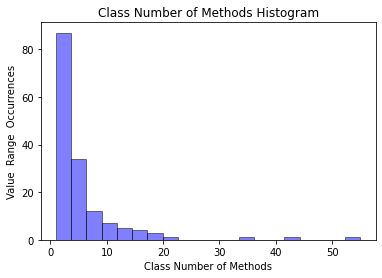

Min = 1
Max = 55
Average = 5.4231
Median = 3.0
Standard Deviation = 6.8967
0.95 of data points fall between 4.3288 and 6.5174


In [36]:
# Print statistical information about the number of functions per class
display_numeric_col_hist(flatten_lol(corpus_df['num_funcs']), "Class Number of Methods")
display_numeric_col_stats(flatten_lol(corpus_df['num_funcs']))

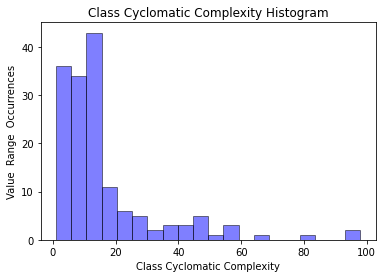

Min = 1
Max = 98
Average = 15.9295
Median = 11.0
Standard Deviation = 17.0813
0.95 of data points fall between 13.2193 and 18.6397


In [37]:
# Print statistical information about the cyclomatic complexity per class
display_numeric_col_hist(flatten_lol(corpus_df['class_ccn']), "Class Cyclomatic Complexity")
display_numeric_col_stats(flatten_lol(corpus_df['class_ccn']))

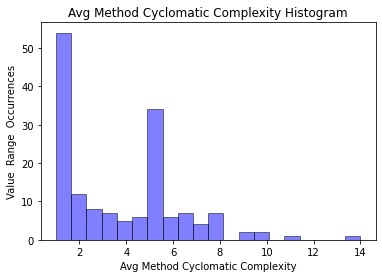

Min = 1.0
Max = 14.0
Average = 3.7015
Median = 3.3264
Standard Deviation = 2.5806
0.95 of data points fall between 3.2921 and 4.111


In [38]:
# Print statistical information about the average cyclomatic complexity of functions in each class
display_numeric_col_hist(flatten_lol(corpus_df['avg_func_ccn']), "Avg Method Cyclomatic Complexity")
display_numeric_col_stats(flatten_lol(corpus_df['avg_func_ccn']))

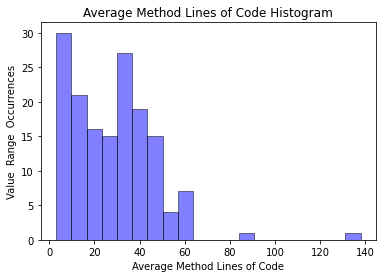

Min = 3.0
Max = 138.0
Average = 27.8038
Median = 28.3889
Standard Deviation = 19.1197
0.95 of data points fall between 24.7702 and 30.8375


In [39]:
# Print statistical information about the average number of lines of code for functions in each class
display_numeric_col_hist(flatten_lol(corpus_df['avg_func_nloc']), "Average Method Lines of Code")
display_numeric_col_stats(flatten_lol(corpus_df['avg_func_nloc']))

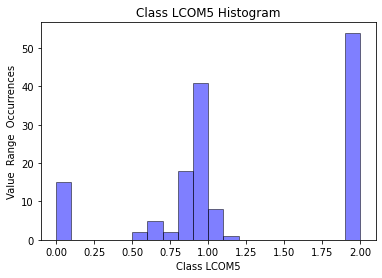

Min = 0.0
Max = 2.0
Average = 1.2139
Median = 0.969
Standard Deviation = 0.6621
0.95 of data points fall between 1.1052 and 1.3226


In [40]:
# Print statistical information about the average cyclomatic complexity of functions in each class
display_numeric_col_hist(flatten_lol(corpus_df['class_lcom5']), "Class LCOM5")
display_numeric_col_stats(flatten_lol(corpus_df['class_lcom5']))

In [0]:
# https://github.com/priv-kweihmann/multimetric
# The above link is another possible tool to easily calculate code metrics for various languages

In [0]:
# https://books.google.com/books?id=DxuGi5h2-HEC&pg=PA140&lpg=PA140&dq=do+header+files+in+c+have+a+cyclomatic+complexity&source=bl&ots=0WxxjeX9rR&sig=ACfU3U1QnoKnwrsj4YbSQxATeaoYMvBWwg&hl=en&sa=X&ved=2ahUKEwijtqKxhJXoAhUSXa0KHctQD38Q6AEwAnoECAkQAQ#v=onepage&q=do%20header%20files%20in%20c%20have%20a%20cyclomatic%20complexity&f=false
# The abover link goes to an article discussing cyclomatic complexity and c header files

In [0]:
# http://site.iugaza.edu.ps/mroos/files/Software-Metrics1.pdf
# The above link is a pdf that explains every LCOM metric

In [0]:
# https://hal.inria.fr/hal-00646878/file/Duca11b-Cutter-deliverable11-SoftwareMetrics.pdf
# Another good article about the cohesion metrics among others

# Scratch Code (Testing)

In [0]:
thing_class = """class OtherClass:
    def __init__(self, name):
        self.name = name

    def complex_func(self):
        if 1 > 3:
            print("HEYO")
        else:
            if 3 > 7:
                print("wow")
            elif 4 == 5:
                print("2")
            elif 5 == 5:
                print("3")
        return "return"

    def ref_func(self):
        self.name = "Wils"
"""
special = thing_class.split('\n')
print(len(thing_class))
print(thing_class[23], end="")
print("TEST")
print(special[0][1], end="")
print("TEST")

391
eTEST
lTEST


In [0]:
DATA = lizard.analyze_file.analyze_source_code("thing.py", thing_class)

In [0]:
print(DATA.__dict__)
print(DATA.CCN)
for i in range(len(DATA.function_list)):
    print(DATA.function_list[i].__dict__)

{'filename': 'thing.py', 'nloc': 16, 'function_list': [<lizard.FunctionInfo object at 0x7fe679880f60>, <lizard.FunctionInfo object at 0x7fe679880fd0>, <lizard.FunctionInfo object at 0x7fe67983e080>], 'token_count': 73}
7
{'cyclomatic_complexity': 1, 'nloc': 2, 'token_count': 12, 'name': '__init__', 'long_name': '__init__( self , name )', 'start_line': 2, 'end_line': 3, 'parameters': ['self', 'name'], 'filename': 'thing.py', 'top_nesting_level': 1, 'length': 2, 'fan_in': 0, 'fan_out': 0, 'general_fan_out': 0}
{'cyclomatic_complexity': 5, 'nloc': 11, 'token_count': 45, 'name': 'complex_func', 'long_name': 'complex_func( self )', 'start_line': 5, 'end_line': 15, 'parameters': ['self'], 'filename': 'thing.py', 'top_nesting_level': 1, 'length': 11, 'fan_in': 0, 'fan_out': 0, 'general_fan_out': 0}
{'cyclomatic_complexity': 1, 'nloc': 2, 'token_count': 10, 'name': 'ref_func', 'long_name': 'ref_func( self )', 'start_line': 17, 'end_line': 18, 'parameters': ['self'], 'filename': 'thing.py', 'to

In [0]:
def test():
    a = 1

l = []
l.append(test())
print(l)

[None]


In [0]:
Language.build_library(
    # Store the library in the `build` directory
    'build/my-languages.so',

    # Include one or more languages
    [
        'tree-sitter-c',
        # 'tree-sitter-cpp',
        'tree-sitter-java',
        # 'tree-sitter-javascript',
        # 'tree-sitter-python'
    ]
)

C_LANGUAGE = Language('build/my-languages.so', 'c')
# CPP_LANGUAGE = Language('build/my-languages.so', 'cpp')
JAVA_LANGUAGE = Language('build/my-languages.so', 'java')
# JS_LANGUAGE = Language('build/my-languages.so', 'javascript')
# PY_LANGUAGE = Language('build/my-languages.so', 'python')

lang_builds = {'c':C_LANGUAGE, 'java':JAVA_LANGUAGE}

parser = Parser()
ext = 'java'
parser.set_language(lang_builds[ext])
test_df = simulate_getting_dataframes_from_mongo()
tree = parser.parse(bytes(test_df["contents"][0], "utf8"))

In [0]:
# root_node = tree.root_node
# text = test_df["contents"][0]
# for a in range(len(root_node.children)):
#     if root_node.children[a].type == "class_declaration":
#         class_dec = root_node.children[a]
#         for b in range(len(class_dec.children)):
#             if class_dec.children[b].type == "class_body":
#                 class_body = class_dec.children[b]
#                 for c in range(len(class_body.children)):
#                     if class_body.children[c].type == "field_declaration":
#                         field_dec = class_body.children[c]
#                         for d in range(len(field_dec.children)):
#                             if field_dec.children[d].type == "variable_declarator":
#                                 # word = ""
#                                 # for i in range(var_dec.children[e].start_byte, var_dec.children[d].end_byte):
#                                 #     word += text[i]
#                                 # print(word)
#                                 var_dec = field_dec.children[d]
#                                 for e in range(len(var_dec.children)):
#                                     if var_dec.children[e].type == "identifier":
#                                         word = ""
#                                         for i in range(var_dec.children[e].start_byte, var_dec.children[e].end_byte):
#                                             word += text[i]
#                                         print(word)
# print("NOW PRINTING TEXT")
# print("NOW PRINTING TEXT")
# print("NOW PRINTING TEXT")
# print("NOW PRINTING TEXT")
# print("NOW PRINTING TEXT")
# print("NOW PRINTING TEXT")
# print("NOW PRINTING TEXT")
# print("NOW PRINTING TEXT")
# print("NOW PRINTING TEXT")
# print("NOW PRINTING TEXT")
# print("NOW PRINTING TEXT")
# print("NOW PRINTING TEXT")
# print(text)

In [0]:
print(test_df["contents"][0])

package interfacce;
import java.awt.*;
import java.awt.event.*;
import common.utility.*;
import common.def.*;
import java.util.Date;
import moduli.*;

public class RicercaAddebiti extends Frame 
{  
    
    //Dichiarazioni di variabili
    Panel panel1, panel2, panel3;
    Label  etichetta1, label1, label3;
    List lista;
    Button  Annulla, Cerca;
    TextField stanza;
    GridBagLayout gridbag = new GridBagLayout();
	Frame padre = new Frame();
    Frame figlio;
    ListaAddebiti L;
    Addebito add;
    float totale_add;
    
    public RicercaAddebiti(Frame p)
    {
        super("Ricerca degli addebiti");
        padre = p;
        padre.setEnabled(false);
        setupPanels();
        init();
        pack();
        setVisible(true); 
    }
                     
        void setupPanels()
        {  
			this.setFont(ConfigurazioneSistema.font_base);
            //Creo due pulsanti  
            Annulla = new Button(" Fine  ");
            Cerca = new Button(" Cerca ");

      

In [0]:

def find_string_in_file(node, pattern, text):
    if len(node.children) > 0:
        count = 0
        for i in node.children:
            count += find_string_in_file(i, pattern, text)
        return count
    else:
        word = ""
        for i in range(node.start_byte, node.end_byte):
            # print(text[i], end="")
            word += text[i]
        # print()
        if word == pattern:
            print(f"Found. Start byte: {node.start_point}, end byte: {node.end_point}")
            return 1
        else:
            return 0
node = tree.root_node
num_found = find_string_in_file(node, "p", test_df["contents"][1])
print(num_found)

Found. Start byte: (10, 14), end byte: (10, 15)
Found. Start byte: (17, 8), end byte: (17, 9)
Found. Start byte: (26, 19), end byte: (26, 20)
Found. Start byte: (33, 69), end byte: (33, 70)
4


In [0]:
query = JAVA_LANGUAGE.query("""
(binary_expression
    left: ("etichetta")
""")

captures = query.captures(tree.root_node)

SyntaxError: ignored

In [0]:
assert len(captures) == 2
assert captures[0][0] == function_name_node
assert captures[0][1] == "function.def"

In [0]:
cursor = tree.walk()
print(cursor.node.type)
cursor.goto_next_sibling
cursor

program


In [0]:
print(cursor.node.type)
print(cursor.goto_first_child)

program


In [0]:
!pip install multimetric

     |████████████████████████████████| 921kB 6.8MB/s 
  Created wheel for multimetric: filename=multimetric-1.1.3-cp36-none-any.whl size=20170 sha256=0d755e6c6634a50c74264bff0a29dab99642f5051bf7c6ad1c2d3d637a2b1403
  Stored in directory: /root/.cache/pip/wheels/6d/c7/81/52b4323f26674931ea81e0d7589a71081e05e88426004c5331
Successfully built multimetric
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: Pygments 2.1.3
    Uninstalling Pygments-2.1.3:
      Successfully uninstalled Pygments-2.1.3


In [0]:
import multimetric

In [0]:
multimetric.rea

In [0]:
if 0:
    print("Hey")

In [0]:
print(round(1236721.8237468732, 3))

1236721.824


In [0]:
!pip install lizard

In [0]:
import subprocess
import json
def add_lizard_mccabe_metrics(df, col):
    mccabe = []
    sloc = []
    comments = []
    ratio = []
    for i in range(len(df)):
        if i == 99:
            print("At file #100", end="")
        if ((i + 1) % 200) == 0:
            print(", file #" + str(i + 1), end="")
        ext = df["file_name"][i].split('.')[-1]
        if ext == 'h':
            ext = 'c'
        with open(f"temp_file.{ext}", "w", encoding='UTF-8') as fp:
            fp.write(df[col][i])
        out = subprocess.Popen(['metrics', '-q', '--format=json', f"temp_file.{ext}"], 
                               stdout=subprocess.PIPE, 
                               stderr=subprocess.STDOUT)
        stdout,stderr = out.communicate()
        metrics_data = json.loads(stdout)
        mccabe.append(metrics_data['files'][f"temp_file.{ext}"]['mccabe'])
        sloc.append(metrics_data['files'][f"temp_file.{ext}"]['sloc'])
        comments.append(metrics_data['files'][f"temp_file.{ext}"]['comments'])
        ratio.append(metrics_data['files'][f"temp_file.{ext}"]['ratio_comment_to_code'])
#         print(mccabe_data['files'][f'temp_file.{LANGUAGE}'].keys())
        os.remove(f"temp_file.{ext}")
    df["complexity"] = mccabe
    df["code_lines"] = sloc
    df["comments"] = comments
    df["ratio_comment_to_code"] = ratio
    return df

In [0]:
!lizard source_code/est.c

  NLOC    CCN   token  PARAM  length  location  
------------------------------------------------
       7      1     35      2      11 est_logger_stderr@9-19@source_code/est.c
      11      2     53      2      16 est_log_msg@27-42@source_code/est.c
      14      3     66      3      24 est_log@46-69@source_code/est.c
      18      2    154      1      23 printStackTrace@73-95@source_code/est.c
      18      5     91      1      31 est_log_backtrace@99-129@source_code/est.c
       3      1      9      1       3 est_get_version@136-138@source_code/est.c
       3      1      9      1       3 est_get_api_level@148-150@source_code/est.c
       7      2     43      1       9 est_log_version@156-164@source_code/est.c
      10      2     46      2      16 est_init_logger@181-196@source_code/est.c
       4      1     11      1       4 est_enable_backtrace@213-216@source_code/est.c
      42      9    202      3      52 est_read_x509_request@239-290@source_code/est.c
      29      5    135     

In [0]:
!metrics source_code/est.c

Metrics Summary:
Files                       Language        SLOC Comment McCabe 
----- ------------------------------ ----------- ------- ------ 
    1                         Python           9       0      3 
----- ------------------------------ ----------- ------- ------ 
    1                          Total           9       0      3 


In [0]:
import lizard

In [0]:
i = lizard.analyze_file("source_code/Heyo.java")

In [32]:
print(i.CCN)

5


In [29]:
print(i.__dict__)

{'filename': 'source_code/Heyo.java', 'nloc': 23, 'function_list': [<lizard.FunctionInfo object at 0x7f346ce79a58>, <lizard.FunctionInfo object at 0x7f346ce8e828>], 'token_count': 117}


In [45]:
for func in i.function_list:
  print(func.__dict__)
  print(func.name)
  func.name


{'cyclomatic_complexity': 1, 'nloc': 3, 'token_count': 18, 'name': 'ConnectionPoolDataSourc::main', 'long_name': 'ConnectionPoolDataSourc::main( String [ ] args)', 'start_line': 18, 'end_line': 20, 'parameters': ['args'], 'filename': 'source_code/Heyo.java', 'top_nesting_level': 1, 'length': 3, 'fan_in': 0, 'fan_out': 0, 'general_fan_out': 0}
ConnectionPoolDataSourc::main
{'cyclomatic_complexity': 1, 'nloc': 4, 'token_count': 20, 'name': 'ConnectionPoolDataSourc::foo', 'long_name': 'ConnectionPoolDataSourc::foo( int apple)', 'start_line': 22, 'end_line': 25, 'parameters': ['apple'], 'filename': 'source_code/Heyo.java', 'top_nesting_level': 1, 'length': 4, 'fan_in': 0, 'fan_out': 0, 'general_fan_out': 0}
ConnectionPoolDataSourc::foo
{'cyclomatic_complexity': 1, 'nloc': 3, 'token_count': 18, 'name': 'ConnectionPoolDataSource::ConnectionCloser::second_main', 'long_name': 'ConnectionPoolDataSource::ConnectionCloser::second_main( String [ ] args)', 'start_line': 68, 'end_line': 70, 'paramet

In [0]:
print(i.function_list[0].__dict__)

{'cyclomatic_complexity': 3, 'nloc': 8, 'token_count': 35, 'name': 'func', 'long_name': 'func( )', 'start_line': 1, 'end_line': 10, 'parameters': [], 'filename': 'thing.py', 'top_nesting_level': 0, 'length': 10, 'fan_in': 0, 'fan_out': 0, 'general_fan_out': 0}


In [0]:
print(len(i.function_list))

37


In [0]:
i

In [0]:
!metrics thing.py

Metrics Summary:
Files                       Language        SLOC Comment McCabe 
----- ------------------------------ ----------- ------- ------ 
    1                         Python          32       0      9 
----- ------------------------------ ----------- ------- ------ 
    1                          Total          32       0      9 


In [0]:
thing = lizard.analyze_file("thing.py")
print(thing.__dict__)
print(thing.CCN)
for i in range(len(thing.function_list)):
    print(thing.function_list[i].__dict__)


{'filename': 'thing.py', 'nloc': 37, 'function_list': [<lizard.FunctionInfo object at 0x7fe679b602b0>, <lizard.FunctionInfo object at 0x7fe679b604a8>, <lizard.FunctionInfo object at 0x7fe679b60588>, <lizard.FunctionInfo object at 0x7fe679b60518>, <lizard.FunctionInfo object at 0x7fe679b604e0>, <lizard.FunctionInfo object at 0x7fe679b605f8>, <lizard.FunctionInfo object at 0x7fe679b60748>, <lizard.FunctionInfo object at 0x7fe679b60668>], 'token_count': 164}
14
{'cyclomatic_complexity': 1, 'nloc': 2, 'token_count': 10, 'name': '__init__', 'long_name': '__init__( self )', 'start_line': 5, 'end_line': 6, 'parameters': ['self'], 'filename': 'thing.py', 'top_nesting_level': 1, 'length': 2, 'fan_in': 0, 'fan_out': 0, 'general_fan_out': 0}
{'cyclomatic_complexity': 1, 'nloc': 2, 'token_count': 10, 'name': '__init__', 'long_name': '__init__( self )', 'start_line': 9, 'end_line': 10, 'parameters': ['self'], 'filename': 'thing.py', 'top_nesting_level': 2, 'length': 2, 'fan_in': 0, 'fan_out': 0, 'g

In [0]:
thing.function_list

In [0]:
thing.filename

'source_code/est.c'

In [0]:
thing.nloc

1005

In [0]:
print(thing.functions_average)

<bound method FileInformation.functions_average of <lizard.FileInformation object at 0x7f5ed935c978>>


In [0]:
i = lizard.analyze_file.analyze_source_code("AllTests.cpp", "int foo(){}")

In [0]:
i.__dict__

{'filename': 'AllTests.cpp',
 'function_list': [<lizard.FunctionInfo at 0x7f137fbacc18>],
 'nloc': 1,
 'token_count': 6}

In [0]:
i.CCN

1

In [0]:
lizard.analyze_file.analyze_source_code("AllTests.py", "def foo():\n\tif (True): \n\tprint('HI')").CCN

2

In [0]:
import subprocess
import json
def add_mccabe_metrics(df, col):
    mccabe = []
    sloc = []
    comments = []
    ratio = []
    for i in range(len(df)):
        if i == 99:
            print("At file #100", end="")
        if ((i + 1) % 200) == 0:
            print(", file #" + str(i + 1), end="")
        ext = df["file_name"][i].split('.')[-1]
        if ext == 'h':
            ext = 'c'
        with open(f"temp_file.{ext}", "w", encoding='UTF-8') as fp:
            fp.write(df[col][i])
        out = subprocess.Popen(['metrics', '-q', '--format=json', f"temp_file.{ext}"], 
                               stdout=subprocess.PIPE, 
                               stderr=subprocess.STDOUT)
        stdout,stderr = out.communicate()
        metrics_data = json.loads(stdout)
        mccabe.append(metrics_data['files'][f"temp_file.{ext}"]['mccabe'])
        sloc.append(metrics_data['files'][f"temp_file.{ext}"]['sloc'])
        comments.append(metrics_data['files'][f"temp_file.{ext}"]['comments'])
        ratio.append(metrics_data['files'][f"temp_file.{ext}"]['ratio_comment_to_code'])
#         print(mccabe_data['files'][f'temp_file.{LANGUAGE}'].keys())
        os.remove(f"temp_file.{ext}")
    df["complexity"] = mccabe
    df["code_lines"] = sloc
    df["comments"] = comments
    df["ratio_comment_to_code"] = ratio
    return df